In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 신경망과의 첫 만남

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 2장 1절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

케라스 파이썬 라이브러리를 사용하여 손글씨 숫자 분류를 학습하는 구체적인 신경망 예제를 살펴보겠습니다. 케라스나 비슷한 라이브러리를 사용한 경험이 없다면 당장은 이 첫 번째 예제를 모두 이해하지 못할 것입니다. 아직 케라스를 설치하지 않았을지도 모릅니다. 괜찮습니다. 다음 장에서 이 예제를 하나하나 자세히 설명합니다. 코드가 좀 이상하거나 요술처럼 보이더라도 너무 걱정하지 마세요. 일단 시작해 보겠습니다.

여기에서 풀려고 하는 문제는 흑백 손글씨 숫자 이미지(28x28 픽셀)를 10개의 범주(0에서 9까지)로 분류하는 것입니다. 머신 러닝 커뮤니티에서 고전으로 취급받는 데이터셋인 MNIST를 사용하겠습니다. 이 데이터셋은 머신 러닝의 역사만큼 오래되었고 많은 연구에 사용되었습니다. 이 데이터셋은 1980년대에 미국 국립표준기술연구소에서 수집한 6만 개의 훈련 이미지와 1만 개의 테스트 이미지로 구성되어 있습니다. MNIST 문제를 알고리즘이 제대로 작동하는지 확인하기 위한 딥러닝계의 ‘Hello World’라고 생각해도 됩니다. 머신 러닝 기술자가 되기까지 연구 논문이나 블로그 포스트 등에서 MNIST를 보고 또 보게 될 것입니다.

MNIST 데이터셋은 넘파이 배열 형태로 케라스에 이미 포함되어 있습니다:

In [111]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images`와 `train_labels`가 모델이 학습해야 할 훈련 세트를 구성합니다. 모델은 `test_images`와 `test_labels`로 구성된 테스트 세트에서 테스트될 것입니다. 이미지는 넘파이 배열로 인코딩되어 있고 레이블은 0에서부터 9까지의 숫자 배열입니다. 이미지와 레이블은 일대일 관계를 가집니다.

훈련 데이터를 살펴보겠습니다:

In [88]:
train_images.shape

(60000, 784)

In [4]:
train_images[0, 10:15, 10:15]

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

In [5]:
len(train_labels)

60000

In [6]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

다음은 테스트 데이터입니다:

In [112]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

In [9]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

다섯 번째 샘플을 맷플롯립 라이브러리를 사용해 확인해 보겠습니다.

In [10]:
!dir/w

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 3426-D141

 C:\Users\JMLAP\OneDrive - seoultech.ac.kr\documents\repositories\statistics\deeplearning 디렉터리

[.]
[..]
[.ipynb_checkpoints]
2.1-a-first-look-at-a-neural-network.ipynb
               1개 파일              22,027 바이트
               3개 디렉터리  129,644,208,128 바이트 남음


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

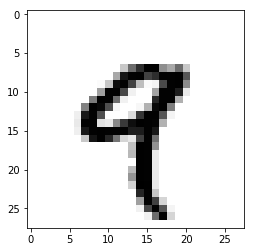

In [12]:
digit = train_images[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

작업 순서는 다음과 같습니다. 먼저 훈련 데이터 `train_images`와 `train_labels`를 네트워크에 주입합니다. 그러면 네트워크는 이미지와 레이블을 연관시킬 수 있도록 학습됩니다. 마지막으로 `test_images`에 대한 예측을 네트워크에게 요청합니다. 그리고 이 예측이 `test_labels`와 맞는지 확인할 것입니다.

신경망을 만들어 보겠습니다. 여기에서도 다음 코드를 완전히 이해하지 않아도 괜찮습니다.

In [18]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

신경망의 핵심 구성 요소는 일종의 데이터 처리 필터라고 생각할 수 있는 층입니다. 어떤 데이터가 들어가면 더 유용한 형태로 출력됩니다. 조금 더 구체적으로 층은 주어진 문제에 더 의미 있는 표현을 입력된 데이터로부터 추출합니다. 대부분의 딥러닝은 간단한 층을 연결하여 구성되어 있고, 점진적으로 데이터를 정제하는 형태를 띠고 있습니다. 딥러닝 모델은 데이터 정제 필터(층)가 연속되어 있는 데이터 프로세싱을 위한 여과기와 같습니다.

이 예에서는 조밀하게 연결된 (또는 완전 연결된) 신경망 층인 `Dense` 층 2개가 연속되어 있습니다. 두 번째 (즉, 마지막) 층은 10개의 확률 점수가 들어 있는 배열(모두 더하면 1입니다)을 반환하는 소프트맥스 층입니다. 각 점수는 현재 숫자 이미지가 10개의 숫자 클래스 중 하나에 속할 확률입니다.

신경망이 훈련 준비를 마치기 위해서 컴파일 단계에 포함될 세 가지가 더 필요합니다:

* 손실 함수 : 훈련 데이터에서 신경망의 성능을 측정하는 방법으로 네트워크가 옳은 방향으로 학습될 수 있도록 도와 줍니다.
* 옵티마이저: 입력된 데이터와 손실 함수를 기반으로 네트워크를 업데이트하는 메커니즘입니다.
* 훈련과 테스트 과정을 모니터링할 지표 : 여기에서는 정확도(정확히 분류된 이미지의 비율)만 고려하겠습니다.

손실 함수와 옵티마이저의 정확한 목적은 이어지는 두 개의 장에서 자세히 설명하겠습니다.

In [19]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


- w1 = (784, 512) -> 784 * 512 (28\*28 = 784)
- b1 = (512,)

In [20]:
# GPU로 계산할때 GPU의 메모리보다 초과한 parameter를 계산했을때 오류발생
28*28*512 + 512

401920

In [21]:
# w2 = (512,10)
# b2 = (10,)
512*10 + 10

5130

In [22]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

훈련을 시작하기 전에 데이터를 네트워크에 맞는 크기로 바꾸고 모든 값을 0과 1 사이로 스케일을 조정합니다. 예를 들어, 앞서 우리의 훈련 이미지는 `[0, 255]` 사이의 값인 `uint8` 타입의 `(60000, 28, 28)` 크기를 가진 배열로 저장되어 있습니다. 이 데이터를 0과 1 사이의 값을 가지는 `float32` 타입의 `(60000, 28 * 28)` 크기의 배열로 바꿉니다.

In [23]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

또한, 레이블을 범주형으로 인코딩해야 합니다. 이 단계는 3장에서 자세히 설명하겠습니다:

In [24]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

이제 신경망을 훈련시킬 준비가 되었습니다. 케라스에서는 `fit` 메서드를 호출하여 훈련 데이터에 모델을 학습시킵니다:

In [25]:
hist = network.fit(train_images, train_labels, epochs=5, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.2543 - acc: 0.9265
Epoch 2/5
60000/60000 [==============================] - 5s 91us/step - loss: 0.1048 - acc: 0.9687: 2s - - ETA: 0s - loss: 0.1074
Epoch 3/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0690 - acc: 0.9796
Epoch 4/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0500 - acc: 0.9853
Epoch 5/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0368 - acc: 0.9888


훈련하는 동안 두 개의 정보가 출력됩니다. 훈련 데이터에 대한 네트워크의 손실과 정확도입니다.

훈련 데이터에 대해 0.989(98.9%)의 정확도를 금방 달성합니다. 이제 테스트 세트에서도 모델이 잘 작동하는지 확인해 보겠습니다:

In [26]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 62us/step


In [27]:
print('test_acc:', test_acc)

test_acc: 0.9792


테스트 세트의 정확도는 97.8%로 나왔습니다. 훈련 세트 정확도보다는 약간 낮습니다. 훈련 정확도와 테스트 정확도 사이의 차이는 과대적합 때문입니다. 이는 머신 러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 경향을 말합니다. 과대적합은 3장에서 자세하게 논의하겠습니다.

이것으로 첫 번째 예제가 마무리되었습니다. 20줄 미만의 파이썬 코드로 손글씨 숫자를 분류하는 신경망을 만들고 훈련시켰습니다. 다음 장에서 여기서 보았던 코드 하나하나를 상세하게 설명하고 이들이 의미하는 바를 명확하게 설명하겠습니다. 이제 텐서, 신경망에 주입하는 데이터의 저장 형태, 층을 만들어주는 텐서 연산, 신경망을 훈련 샘플로부터 학습시키는 경사 하강법에 대해 알아보겠습니다.

[실습]
4개의 layer를 생성한다.
- 256개의 unit을 사용하고, activation은 relu
- 128개의 unit을 사용하고, activation은 relu
- 64개의 unit을 사용하고, activation은 leakage relu
- 분류 레이어를 사용하라.

compile시 optimizer를 adam으로 설정한다.

모델을 학습 중, 20% 평가용으로 사용하고, test 데이터에 대한 정확도를 평가한다.

최종적으로 loss를 시각화한다.



In [113]:
relu2 = keras.layers.LeakyReLU(alpha=0.1)

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation=relu2))
model.add(layers.Dense(10, activation='softmax'))

In [127]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [128]:

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(10, activation='softmax'))

In [129]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_73 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [131]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [132]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [133]:
hist = model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/20
60000/60000 [==============================] - 4s 70us/step - loss: 0.2664 - acc: 0.9222
Epoch 2/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0975 - acc: 0.9705
Epoch 3/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.0646 - acc: 0.9797
Epoch 4/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.0487 - acc: 0.9843
Epoch 5/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.0360 - acc: 0.9886
Epoch 6/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.0289 - acc: 0.9903
Epoch 7/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.0225 - acc: 0.9928
Epoch 8/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0205 - acc: 0.9932
Epoch 9/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0161 - acc: 0.9947
Epoch 10/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.0171 - acc: 0.9943